In [28]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [29]:
import numpy as np
import pandas as pd

In [30]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [32]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [33]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [34]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [35]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [36]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [37]:
# Import 'inspect' dependency
from sqlalchemy import inspect

In [38]:
# Iterate through 'Measurement' table to
# find names and types of columns
columns = inspect(engine).get_columns('Measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [39]:
# Get an idea what data in 'Measurement' looks like
engine.execute('SELECT * FROM Measurement LIMIT 7').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0)]

In [40]:
# Find total entries in 'Measurement'
total_dates = session.query(func.count(Measurement.date)).all()
print(f"Total entries in table is {total_dates}")

Total entries in table is [(19550,)]


In [41]:
# Oldest date in table 'Measurement'
session.query(Measurement.date).order_by(Measurement.date.asc()).first()

('2010-01-01')

In [42]:
# Limit query to only dates from 2010-01-01 to 2011-1-01
# in 'Measurement' table, include date and percipitation amount
yr2010_date_prcp_results = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= '2010-01-01').\
                    filter(Measurement.date <= '2011-01-01').\
                    order_by(Measurement.date).all()
# need order_by(Measurement.date).all()??

In [43]:
# Create DataFrame out of yr2010_dat_prcp query
df_yr2010_date_prcp = pd.DataFrame(yr2010_date_prcp_results[:], 
                                   columns=['Date', 'Precipitation'])
df_yr2010_date_prcp.head()

,Date,Precipitation
0,2010-01-01,0.08
1,2010-01-01,0.28
2,2010-01-01,0.21
3,2010-01-01,0.15
4,2010-01-01,0.15


In [44]:
# Set index of df_yr2010_date_prcp to 'Date'
df_yr2010_date_prcp.set_index('Date', inplace=True)
df_yr2010_date_prcp.head()

,Precipitation
Date,
2010-01-01,0.08
2010-01-01,0.28
2010-01-01,0.21
2010-01-01,0.15
2010-01-01,0.15


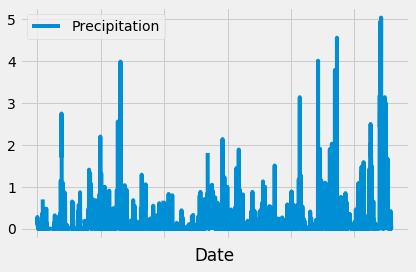

In [45]:
# Plot df_yr2010_date_prcp
df_yr2010_date_prcp.plot()
plt.tight_layout()

In [46]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_yr2010_date_prcp['Precipitation'].describe()

count    2688.000000
mean        0.138549
std         0.411545
min         0.000000
25%         0.000000
50%         0.010000
75%         0.090000
max         5.040000
Name: Precipitation, dtype: float64

# Design a query to show how many stations are available in this dataset

In [47]:
# Iterate through 'Station' table to
# find names and types of columns
columns = inspect(engine).get_columns('Station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [48]:
# Get an idea what data in 'Station' looks like
engine.execute('SELECT * FROM Station LIMIT 2').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)]

In [49]:
# Find total entries in 'Station'
total = session.query(func.count(Station.name)).all()
print(f"Total entries in table is {total}")

Total entries in table is [(9,)]


In [50]:
# # Limit query for station from 'Measurement' table
# stations = session.query(Measurement.station)

# # Create query for station and name from 'Station' table
# station_name = session.query(Station.station, )

# What are the most active stations? 

In [51]:
# Join 'Measurement' stats with name of stations from 'Station'
names_stations = engine.execute('SELECT s.name, m.station, m.tobs \
                FROM Measurement as m\
                INNER JOIN Station as s\
                ON m.station = s.station;').fetchall()

In [57]:
# Create DataFrame out of yr2010_dat_prcp query
station_readings = pd.DataFrame(names_stations[:], 
                                   columns=['Station Name', 
                                            'Total Readings',
                                            'Avg Temperature'])

# Group readings by 'Station Name' and sort by 'Total Readings'
station_readings_grp = station_readings.groupby(['Station Name']).count().\
                        sort_values(by='Total Readings', ascending=False)

# Drop 'Avg Temperature' column
station_readings_grp.drop(labels='Avg Temperature', axis=1, inplace=True)

# Show grouped station readings DataFrame
station_readings_grp


,Total Readings
Station Name,
"WAIHEE 837.5, HI US",2772
"WAIKIKI 717.2, HI US",2724
"KANEOHE 838.1, HI US",2709
"WAIMANALO EXPERIMENTAL FARM, HI US",2669
"MANOA LYON ARBO 785.2, HI US",2612
"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
"HONOLULU OBSERVATORY 702.2, HI US",1979
"PEARL CITY, HI US",1372
"UPPER WAHIAWA 874.3, HI US",511


# Lowest and Highst Temperature Recordings per Station

In [59]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# Create query for from 'Measurement' for temperature and group by station
temperature_all = session.query(Measurement.station, Measurement.tobs).all()

In [60]:
# Create pandas DataFrame from 'temperature_all'
temperature_df = pd.DataFrame(temperature_all[:], columns=['Station Code', 'Temperature'])

# Group by 'Station ID' to find min temperature
# in ascending order
min_temp_df = temperature_df.groupby('Station Code').min().sort_values(by='Temperature', ascending=True)

# Reset index, so 'Station ID' becomes column
min_temp_df.reset_index(inplace=True)

# Chceck min_temp_df
min_temp_df

# Save min temp and station with min temp into separate variables
min_temp = min_temp_df['Temperature'][0]
min_temp_station = min_temp_df['Station Code'][0]


# Print min temp and station with min temp
print(f"The lowest temperature, {min_temp}, was recoreded at {min_temp_station}.")

The lowest temperature, 53.0, was recoreded at USC00511918.


In [61]:
# Group by 'Station ID' to find max temperature
# in descending order
max_temp_df = temperature_df.groupby('Station Code').max().sort_values(by='Temperature', ascending=False)

# Reset index, so 'Station ID' becomes column
max_temp_df.reset_index(inplace=True)

# Chceck min_temp_df
max_temp_df

# Save min temp and station with min temp into separate variables
max_temp = max_temp_df['Temperature'][0]
max_temp_station = max_temp_df['Station Code'][0]


# Print min temp and station with min temp
print(f"The highest temperature, {max_temp}, was recoreded at {max_temp_station}.")

The highest temperature, 87.0, was recoreded at USC00511918.


# Average Temperature for Most Active Station

In [65]:
# Select station name and station code from 'Station'
station_name_code = engine.execute('SELECT s.name, s.station\
                                   FROM Station as s;').fetchall()

# Make station_name_code a pd DataFrame
station_name_code_df = pd.DataFrame(station_name_code[:], 
                                    columns=['Station Name', 'Station Code'])

# Group readings by 'Station Name' and find mean temp for each station
station_avg_temp_grp = station_readings.groupby(['Station Name']).mean()

# Check newly grouped df
station_avg_temp_grp.head(1)

,Avg Temperature
Station Name,
"HONOLULU OBSERVATORY 702.2, HI US",71.615968


In [68]:
# Join station_readings_grp with station_name_num_df
station_readings_code = station_avg_temp_grp.join(
    station_name_code_df.set_index('Station Name'), on='Station Name')

# Check newly joined df
station_readings_code.head(1)

,Avg Temperature,Station Code
Station Name,,
"HONOLULU OBSERVATORY 702.2, HI US",71.615968,USC00511918


In [77]:
# Join with 'Total Readings' from df station_readings_grp
station_readings_avgTemp = station_readings_code.join(
station_readings_grp, on="Station Name").sort_values('Total Readings', ascending=False)

# Check newly joined table
station_readings_avgTemp.reset_index(inplace=True)
station_readings_avgTemp

# Make variables to find avg temp of satation with most readings
most_readings_station = station_readings_avgTemp['Station Name'][0]
most_readings_avgTemp = station_readings_avgTemp['Avg Temperature'][0]
most_readings_num = station_readings_avgTemp['Total Readings'][0]

print(f"{most_readings_station} is the station with the most temperature  \
readings at a total of {most_readings_num} readings and an \
average temperature reading of {most_readings_avgTemp} F.")

WAIHEE 837.5, HI US is the station with the most temperature  readings at a total of 2772 readings and an average temperature reading of 71.66378066378067 F.


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram





![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

